```[Lorenzo Yizhou Lu, 21 Apr 2020 4:07pm]:```  
```Function series and manual```  
To optimize this question, we have to get the data first. In the next cell, I listed the functions for simulating.  
This is not hard to implement but requires an understanding in this process.  

1. The function 1 just returns a idct(inverse discrete cosine transform) matrix, which is just like MATLAB. This function has not to be called directly by programmer!   

2. The function 2 returns a matrix with $r \times c$ length in both rows and columns. This matrix is aimed to convert an process, where we idct a image(2D) and then reshape it as a vector, into an equivalent process, where we reshape this image first(1D) and then tranform it with this returned vector. They both give the same final vector. Attention: the reshape function in Julia traverse along columns then rows, thus, ```reshape(image',(:,1))``` in Julia is exact same as ```reshape(image,r_image * c_image,1)``` in MATLAB. The <strong>transposing</strong> is necessary! This function is not for data aquiring. Recalling the compressed sensing formula: $$y_{m \times 1} = \phi_{m \times n}\psi_{n \times n}a_{n \times 1}$$ We are optimizing the $a$, and this function returns $\psi$. We know $\psi a = x$, and the simulated intensity measurements $y = \phi x$. When considering the <strong>Poisson noise</strong>, the exact measured signal $\hat{y} \sim\mathcal P(X = y)$. <u>Anyways, function 2 should be called only in optimization process!</u>  

3. Function 3 is just returning $\hat{y} \sim\mathcal P(X = y)$.  

4. Do Not Call it directly! If necessary: Function 4 (please use the second version, <strong>DMD_freq_pattern(r,c, cycles)</strong>).  

5. The function 5 returns $\phi$. <u>Before the simulation, save this returned matrix, and upload it to function 6</u>. It is a good way to save time, if you would like to do muitiple simulations based on the same DMD_basis. <u>This saved $\phi$ will still be used during the optimization process</u>! 

6. Function 6 returns the final simulated result $\hat{y}$. Parameters: photon_number(how many photons per pixel during each measurement), cycles(how many measurements), upload_image, upload_basis(DMD_basis, or $\phi$).  

```[Lorenzo Yizhou Lu, 21 Apr 2020 10:32pm]:```  
```Objective and Constraints```  
I designed three parts for this project.  For compressed sensing, the <strong>Lasso regression</strong> is also required. After we optimize $a$, we can reconstruct the image by $\psi a$.    
<strong>(A).</strong>  
Variables: 
1. The vector, $a$, standing for the coefficents in DCT domain. $a \in \mathbb{R}^n$.    
2. The number of measurements, m, or cycles in these functions. $m \in \mathbb{N}$.  

Objective: Find the best reconstructed image under Poisson Noise.  
Constraints: 
1. Assuming our device has a constraint that it could only detect $10^6$ photons per second. For example, if we finish $10^4$ measurements during a second, each one cannot have more than $100$ photons.

<strong>(B).</strong>  
variables:  
1. The DMD_basis, $\psi$. 
2. $\phi$.  

Objective: Find the smallest coherence;  
Constraints:  
1. $\psi \in \{0,1\}^{(m \times n)}$.
2. $rank(\psi) = m$.  
3. $\phi \in \mathbb{R}^{(n \times n)}$.  
4. $rank(\phi) = n$.  
The literature says <strong>Noiselets basis</strong> and <strong>Haar wavelets matrix</strong> have low coherence.  

<strong>(C).</strong>  
Variables:   
Acquisition time, $t$.   
$\psi$ modes: random, Walsh and raster scan  
Assuming $\epsilon(t)$ is the error as a function of $t$, but we would like to find a experiment time $t^*$ where we use the least time to reconstruct the best image.  
Objective: minimize $\epsilon(t) + \lambda \|t\|_1$.  
Constraints:  
$\int_{t_0}^{t_0 + 1} n(t) dt \le 10^6, \forall t_0 \in R$  



### Process Bar!

In [1]:
using FFTW, LinearAlgebra, Distributions, Random, Images, TestImages, ImageMagick, PyPlot;
function YZ_process_bar(ratio, overwrite = true)
    size = 50;
    i = 1;
    bar = "故国神游，多情应笑我，英年脱发 | ";
    while i <= size * ratio
        bar = bar * "▒";
        i += 1;
    end
    while i <= size
        bar = bar * "░";
        i = i+1;
    end
    bar *= " |";
    bar *= "$(round(ratio*100, digits = 3))%";
    if ratio == 1
        bar *= " ^_^/ Done!"
    end
    if overwrite == true
        print("\r");
    else
        print("\n");
    end
    print(bar); 
    sleep(0.001);
end

YZ_process_bar (generic function with 2 methods)

In [2]:

## 1.
function idctmtx(dims)
    ## produce a DCT matrix like matlab
    diag = I(dims);
    D = zeros(dims,dims);
    for i = 1:dims
        D[:,i] = idct(diag[:,i]);
    end
    return D;
end

## 2.
function IDCT_basis(r_tot,c_tot)
    ## produce a hyper resolution DMD measurement basis series
    ##verified by Python; 
    # making a idct2 matrix in a vector form
    D1 = idctmtx(r_tot);
    D2 = idctmtx(c_tot);
    N = r_tot * c_tot;
    Basis = zeros(N,N);
    
    i = 1;
    for ir = 1:r_tot
        for ic = 1:c_tot
            
            Basis_Vector = D1[ir:ir,:]' * D2[ic:ic,:];
            Basis[i,:] = reshape(Basis_Vector', (1,:));
            i += 1;
        end
        
    end
    return Basis;
end

## 3.
function Poisson_noise(signal)
    return rand.(Poisson.(signal));
end

## 4. This two functions are genrating a 0-1 Walsh Matrix
## for compressed sensing, just select part of this rows
#=
function DMD_freq_pattern_old(r,c, cycles = false)
    if cycles == false || cycles < 0 || cycles > r*c;
        cycles = r*c;
    end
    
    freq_pattern = zeros(r,c);
    ratio = (cycles/r/c)^0.5;
    
    r1 = Int(ceil(ratio * r))-1;
    c1 = Int(ceil(ratio * c))-1;
    
    freq_pattern[1:r1, 1:c1] .= 1;
    
    n_res = cycles - r1 * c1;
    res_index = findall(x->x == 0, freq_pattern[1:r1+1, 1:c1+1]);
    
    index_distance = zeros(length(res_index), 2);
    
    for i = 1:length(res_index)
        index_distance[i,1] = i;
        # res_index[i] is a tuple
        index_distance[i,2] = res_index[i][1]/(r1+0.0) + res_index[i][2]/(c1+0.0);
    end
    
    sorted_index_distance = index_distance[sortperm(index_distance[:,2]),:];
    selected_index = sorted_index_distance[:,1][1:n_res];
    
    for i = 1:n_res
        rc_cartesian = res_index[Int(selected_index[i])];
        freq_pattern[rc_cartesian[1], rc_cartesian[2]] = 1;
    end
    
    return freq_pattern;
    
end
=#

function DMD_freq_pattern(r,c, cycles = false)
     if cycles == false || cycles < 0 || cycles > r*c;
        cycles = r*c;
    end
    
    freq_pattern = zeros(r,c);
    n_res = cycles;
    res_index = findall(x->x == 0, freq_pattern);
    
    
    index_distance = zeros(length(res_index), 2);
    
    for i = 1:length(res_index)
        index_distance[i,1] = i;
        # res_index[i] is a tuple
        index_distance[i,2] = res_index[i][1]/(r+0.0) + res_index[i][2]/(c+0.0);
    end
    
    sorted_index_distance = index_distance[sortperm(index_distance[:,2]),:];
    selected_index = sorted_index_distance[:,1][1:n_res];
    
    for i = 1:n_res
        rc_cartesian = res_index[Int(selected_index[i])];
        freq_pattern[rc_cartesian[1], rc_cartesian[2]] = 1;
    end
    
    return freq_pattern;
end

## 5
function DMD_measure_basis(r, c, cycles = false, tag = "Walsh")
    ## it returns a DMD 0-1 matrix as measure basis
    ## this matrix has "cycles" rows and "r*c" columns
    if cycles == false
        cycles = r*c;
    end
    
    if tag == "Walsh"
        DMD_basis = zeros(cycles, r*c);
        #freq_pattern = DMD_freq_pattern(r,c, cycles);
        freq_pattern = ones(r, c);

        #rows = 1:r*c;
        #rows_selected = randperm(rows)[1:cycles]; 

        index_total = findall(x->x==1.0, freq_pattern);
        index = index_total[randperm(cycles)];
        FT_domain = zeros(r,c);
        for i = 1:length(index)
            current_index = index[i];
            FT_domain[current_index[1], current_index[2]] = 1;
            DMD_zero_one = ceil.(idct(FT_domain)); ## 0-1 pattern on DMD

            DMD_basis[i,:] = reshape(DMD_zero_one',(1,:));
            FT_domain[current_index[1], current_index[2]] = 0;
        end
        return DMD_basis;
    elseif tag == "HyperReso"
        DMD_basis = zeros(cycles, r*c);
        
        freq_pattern = DMD_freq_pattern(r,c, cycles);
        
        index_total = findall(x->x==1.0, freq_pattern);
        index = index_total[randperm(cycles)];
        FT_domain = zeros(r,c);
        for i = 1:length(index)
            current_index = index[i];
            FT_domain[current_index[1], current_index[2]] = 1;
            DMD_zero_one = ceil.(idct(FT_domain)); ## 0-1 pattern on DMD

            DMD_basis[i,:] = reshape(DMD_zero_one',(1,:));
            FT_domain[current_index[1], current_index[2]] = 0;
            
            
        end
        return DMD_basis;
        
    elseif tag == "Random"
        DMD_basis = round.(rand(cycles, r*c))
        return DMD_basis;
    else
        print("Wrong Tag");
    end
end



## 6 direct upload a black white image and get the measurement
function PMT_measure_simu(photon_number, cycles, upload_image, upload_basis, Poisson = true)
    ### photon - number is the photons of each pixel during each measurement
    ### cycles : the compression rate; 
    ### Poisson : true, adding poisson noise
    ### upload_image : Black white image (matrix)
    image = upload_image / maximum(upload_image);
    r_tot, c_tot = size(upload_image);
    #=
    if upload_basis == "null"
        DMD_basis = DMD_measure_basis(r_tot, c_tot, cycles);
    else
        DMD_basis = upload_basis[1:cycles,:];
    end
    =#
    DMD_basis = upload_basis[1:cycles,:];
    
    image_vector = reshape(image', (:, 1));
    image_vector *= photon_number; ## here you are light up a image
    
    measurements = zeros(cycles,1); 
    ### if you want to do RGB image later, set zeros(cycles,3)
    
    for i = 1:cycles
        val = DMD_basis[i:i,:] * image_vector;
        
        if Poisson == true
            val = Poisson_noise(val);
        end
        measurements[i,:] = val;
        #YZ_process_bar(i/cycles);
    end
    
    measurements /= photon_number;
    
    return measurements;
end

## 7 load image as matrix
function Img2matrix(pathname, r = false, c = false, RGB = true)
    img = channelview(load(pathname));
    r0, c0 = size(img[1,:,:]);
    
    if r == false
        r = r0;
    end
    if c == false
        c = c0;
    end
    
    red = imresize(img[1,:,:], (r,c));
    green = imresize(img[2,:,:], (r,c));
    blue = imresize(img[3,:,:], (r,c));
    
    if RGB == true
        matrix = zeros(r,c,3);
        matrix[:,:,1] = red;
        matrix[:,:,2] = green;
        matrix[:,:,3] = blue;
        
    else
        matrix = zeros(r,c);
        matrix = 0.21 * red  + 0.72 * green + 0.07 * blue;
    end
    
    return matrix;
end

Img2matrix (generic function with 4 methods)

## make a Haar 

In [3]:
function Kron(mat1, mat2)
    r1,c1 = size(mat1);
    r2,c2 = size(mat2);
    prod = zeros(r1*r2, c1*c2);
    for r = 1:r1
        for c = 1:c1
            prod[(r-1)*r2 + 1 : r*r2, (c-1)*c2+1, c*c2] = mat1[r1,c1] .* mat2;
        end
    end
    return prod;
end

function inv_Haar_matrix(R)
    #R = edge1*edge2;
    n = ceil(log2(R));
    H = [1 1;1 -1] .* (0.5)^0.5;
    for i = 1:(n-1)
        N = Int(round(2^i));
        top = H;
        bottom = I(N);
        H = [kron(top,[1 1] .* (0.5)^0.5) ; kron(bottom, [1 -1].* (0.5)^0.5)];
    end
    return imresize(H', (R,R));
end

function Haar_basis(r_tot, c_tot)
    D1 = inv_Haar_matrix(r_tot);
    D2 = inv_Haar_matrix(c_tot);
    N = r_tot * c_tot;
    Basis = zeros(N,N);
    
    i = 1;
    for ir = 1:r_tot
        for ic = 1:c_tot
            
            Basis_Vector = D1[ir:ir,:]' * D2[ic:ic,:];
            Basis[i,:] = reshape(Basis_Vector', (1,:));
            i += 1;
        end
    end
    return Basis;
end

Haar_basis (generic function with 1 method)

In [4]:
function Resize(mat, new_size)
    r,c = new_size;
    r0, c0 = size(mat);
    mat2 = zeros(r,c)
    for i = 1:r
        y = Int(ceil(i * r0 / r));
        for j = 1:c
            x = Int(ceil(j * c0 / c));
            mat2[i,j] = mat[y,x];
        end
    end
    return mat2;    
end

function Haar_tree(seed_raw)
    #if sum(abs.(seed_raw)) == 0
        #print("wrong");
    #end
    
    r,c = size(seed_raw);
    r2 = Int(round(r/2));
    c2 = Int(round(c/2));
    seed = Resize(seed_raw, (r2,c2));
    k1 = [1 0; 0 0];
    k2 = [0 1; 0 0];
    k3 = [0 0; 1 0];
    k4 = [0 0; 0 1];
    
    out = zeros(2*r, 2*c);
    
    out[1:r,1:c] = kron(k1, seed);
    out[1:r,c+1:2*c] = kron(k2, seed);
    out[r+1:2*r,1:c] = kron(k3, seed);
    out[r+1:2*r, c+1:2*c] = kron(k4, seed);
    
    return out;
end

function make_tensor(n, seed, row,col)
    # r is the edge
    r = 2^(n);
    
    #r0,c0 = size(matrix);
    #n = Int(round(r0/r));
    tensor = zeros(row,col,2^(2*n));
    layer = 1;
    
    sub = zeros(r,r);
    for i = 1:2^n
        for j = 1:2^n
            
            #sub = matrix[(i-1)*r+1: i*r, (j-1)*r+1:j*r];
            sub[i,j] = 1;
            
            #if sum(abs.(sub)) == 0
                #print("wrong");
            #end
            tensor[:,:,layer] = Resize(kron(sub,seed), (row,col));
            sub[i,j] = 0;
            layer+=1;
        end
    end
    return tensor;
end

function Haar_recursion(row,col)
    ## currently please let row = col = 2^n
    haar_tensor = zeros(row,col,(row*col));
    
    seed1= [1 1; 1 1];
    seed2= [1 -1; 1 -1];
    seed3 = [1 1; -1 -1];
    seed4 = [1 -1; -1 1];
    
    kernel1 = Resize([1 1; 1 1], (row,col));
    kernel2 = Resize([1 -1; 1 -1], (row,col));
    kernel3 = Resize([1 1; -1 -1],(row,col));
    kernel4 = Resize([1 -1; -1 1],(row,col));
    haar_tensor[:,:,1] = kernel1;
    haar_tensor[:,:,2] = kernel2;
    haar_tensor[:,:,3] = kernel3;
    haar_tensor[:,:,4] = kernel4;
    
    layer = 4;
    kernel_edge = row;
    N = 1;
    while kernel_edge >= 4
        
        #kernel2 = Haar_tree(kernel2);
        
        t1 = make_tensor( N, seed2, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        #kernel3 = Haar_tree(kernel3);
        t1 = make_tensor( N, seed3, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        #kernel4 = Haar_tree(kernel4);
        t1 = make_tensor( N, seed4, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        kernel_edge /= 2;     
        N += 1;
    end
    
    haar_2d = zeros(row*col,row*col);
    for i = 1:row*col
        vec = reshape(haar_tensor[:,:,i]', (1,:));
        abs_sum = sum(abs.(vec));
        haar_2d[i,:] = vec ./ abs_sum^0.5;
    end
    
    haar_tensor = nothing;
    
    return haar_2d;
end


Haar_recursion (generic function with 1 method)

### Simulating measurment!
I won't suggest change r and c; 
See the three lines below! Just change comment/uncomment the "DMD_basis" lines  
And run "measure", you can change "photon_number" "cycles" in side!

In [5]:
## reconstruction
using JuMP, Gurobi;

### Hard constriant!

#prod1 = inv_Haar_matrix(r*c)' * img_vector;
#prod = Haar_basis(r,c) * img_vector;
prod1 = Haar_recursion(r,c) * img_vector;
figure();
plot(value.(a), label = "optimal");
plot(prod1, label = "theorectical");
legend();



## Compare DCT basis and Haar basis

prod2 = (IDCT_basis(r,c)) * img_vector;
figure();
plot(prod2, label = "Theorectical");
plot(value.(a), label = "Optimal");
legend();

figure();
#plot((1:length(prod1)), prod1, label = "Haar Coefficients");
plot((1:length(prod2)), prod2, label = "DCT Coefficients");
legend();
bins = 200;
figure();
hist(prod1, bins);
figure();
hist(prod2,bins);

Conclusion:It seems Haar wavelets are more sparse!

### Soft constraint

```[Lorenzo Yizhou Lu 1:41am 4/26/2020]```  
I found the running time when we set the direct Lasso regression objective is <strong>Extremly Long</strong>. It could be a barrier for us to think about a strategy to reconstruct this image during much shorter time.  


In [6]:
#=
#using Ipopt;
lasso = 1e-4;
m = Model(Gurobi.Optimizer);
set_silent(m);
_phi = IDCT_basis(r,c);
tot_mat = DMD_basis*_phi;

a = @variable(m, [1:r*c, 1:1]);
a_abs = @variable(m, [1:r*c, 1:1]);

@constraint(m, a_abs .>= a);
@constraint(m, a_abs .>= -a);

@objective(m, Min, lasso * sum(a_abs) + sum((tot_mat*a - measure).* (tot_mat*a - measure))/(cycles));
optimize!(m);
=#

For Random DMD basis,   
Haar coherence is 256.27;  
DCT coherence is 1807.13;  
  
For dct DMD basis,   
Haar coherence is 320.39;  
DCT coherence is 3353.59;

# Optimization!

## objective 1

### Console

## To sum up: 
$$
\hat{y}_{m \times 1} = \mathcal{P}(\phi_{m \times n}\psi_{n \times n}a_{n \times 1}) \\  
\underset{a}{\text{minimize}} \quad (\hat{y} - \phi \psi a)^2 + \lambda \|a\|_1 $$

$\mathcal{P}$ means Poisson noise is added  
the variable "measure" above is the $\hat{y}$, which is affected by photon_numbers  
the variable "psi" is the $\psi$  
the variable "phi" is the $\phi$  
our objective is to optimize $a$ under different $\hat{y}$

In [13]:
## ratio is just like the cell above
## time 
## Pnoise is boolean
## Phi_select among 1 2 3
## psi_select among 1 2
function GetTheMeasured(ratio, time, Pnoise, phi_select, psi_select, raw_img)
    #r = 64; # no change                                
    #c = 64; # no change                                                                                    
    #filename = "ECE.jpg"; # no change  
    r,c = size(raw_img);
    
    photon_per_second = 1e6;
    
    ratio = minimum([1,ratio]); ## no exceed 1                     *
    ratio = maximum([0,ratio]); ## no less than 0                  *
    cycles = Int(round(r*c*ratio)); # no change                    *
    cycles = maximum([1,cycles]);   #    
    
    if phi_select == 1
        phi = DMD_measure_basis(r,c, cycles, "HyperReso");  #*
    elseif phi_select == 2
        phi = DMD_measure_basis(r,c, cycles, "Random");     #*
    elseif phi_select == 3
        phi = DMD_measure_basis(r,c, cycles, "Walsh");      #*
    else
        print("Bad phi");
        return false;
    end
    
    #raw_img = Img2matrix(filename, r,c, false);  #                 *
    
    img_vector = reshape(raw_img', (:,1));       #                 *
    photon_number = photon_per_second * time / cycles /(r*c) *2; 
    
    if psi_select == 1
        psi = Haar_recursion(r,c)';                              #*;
        ## transpose == inverse.we only use r=inverse transform  *;
    elseif psi_select == 2                         
        psi = (IDCT_basis(r,c));
    else
        print("Bad psi");                                        #*
        return false;
    end
    
    measure = PMT_measure_simu(photon_number, cycles, raw_img, phi, Pnoise);
    
    
    return measure, phi,psi;
    
end

GetTheMeasured (generic function with 1 method)

In [48]:
function Make_dicts(dic, i, item)
    push!(dic, i => item);
    return dic;   
end

function Optimize(y,phi,psi,raw_img, show = true) ## return a mean square error!
    r,c = size(raw_img)
    m = Model(Gurobi.Optimizer);
    set_silent(m);

    measure = y;
    DMD_basis = phi;
    _phi = psi;
    tot_mat = DMD_basis*_phi;

    a = @variable(m, [1:r*c, 1:1]);
    a_abs = @variable(m, [1:r*c, 1:1]);
    #@constraint(m, tot_mat*(a) .== measure);
    @constraint(m, tot_mat*a - measure .<= 1e-1);
    @constraint(m, tot_mat*a - measure .>= -1e-1);
    @constraint(m, a_abs .>= a);
    @constraint(m, a_abs .>= -a);

    @objective(m, Min, sum(a_abs));
    optimize!(m)

    img_recons_vec = _phi * value.(a);
    img_recons = reshape(img_recons_vec, (r,c))';

    img_recons[findall(x->x>1, img_recons)] .= 1;
    img_recons[findall(x->x<0, img_recons)] .= 0;
    
    Error = sum((raw_img .- img_recons).^2)  ./ (r*c);
    
    if show == true
        figure();
        imshow(img_recons);
        comments = "Reconstructed Image $(Error)";
        title(comments);
    end

    #println("Objective value ->", objective_value(m));
    
    a = nothing;
    a_abs = nothing;
    m = nothing;   
    
    return Error;
end

Optimize (generic function with 2 methods)

first step:
create an array "ratio_list", for each element $r_i$, get a $y_i$

## Objective 1

<======>Looping =>1
  1.494291 seconds (84.07 k allocations: 1.029 GiB, 36.08% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  0.593952 seconds (482.65 k allocations: 68.588 MiB)
<======>Looping =>2
  1.099698 seconds (115.75 k allocations: 1.082 GiB, 16.96% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  1.620045 seconds (523.28 k allocations: 144.622 MiB, 2.30% gc time)
<======>Looping =>3
  1.310341 seconds (147.69 k allocations: 1.134 GiB, 30.04% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  3.963514 seconds (564.80 k allocations: 229.781 MiB, 0.92% gc time)
<======>Looping =>4
  1.375221 seconds (179.63 k allocations: 1.186 GiB, 22.53% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  6.850977 seconds (606.22 k allocations: 317.264 MiB, 0.54% gc time)
<====

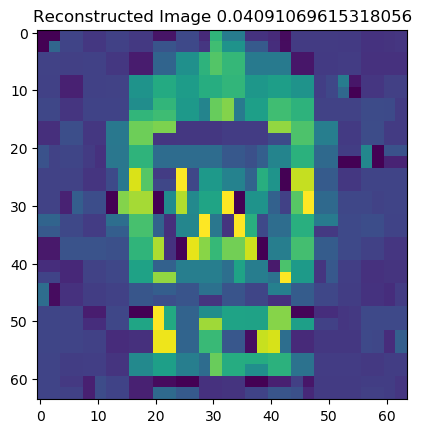

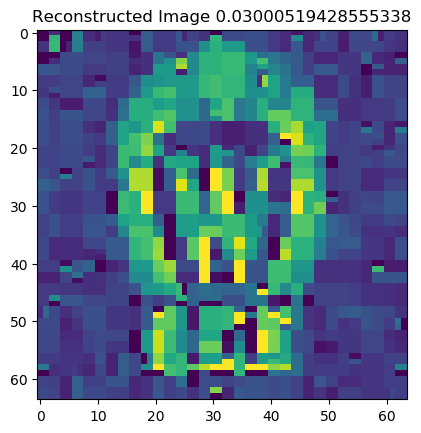

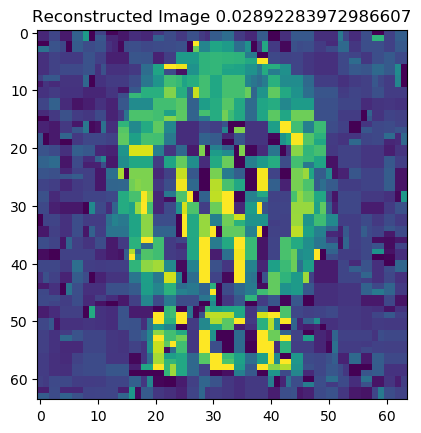

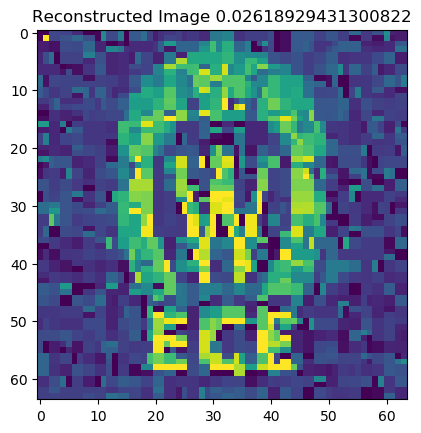

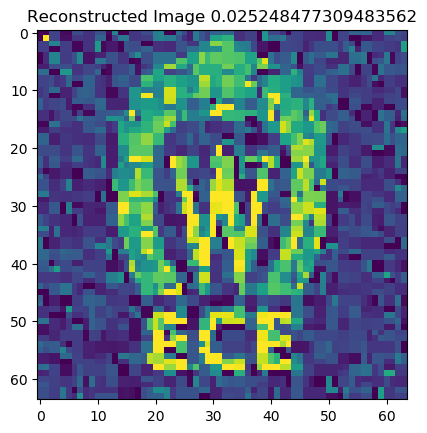

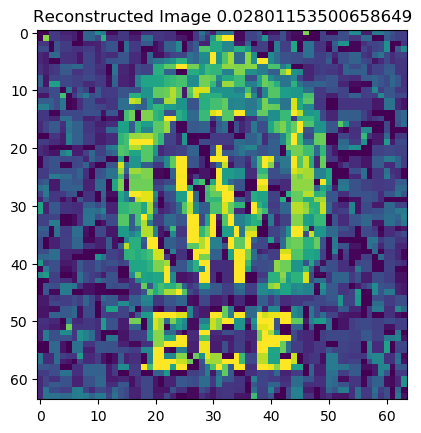

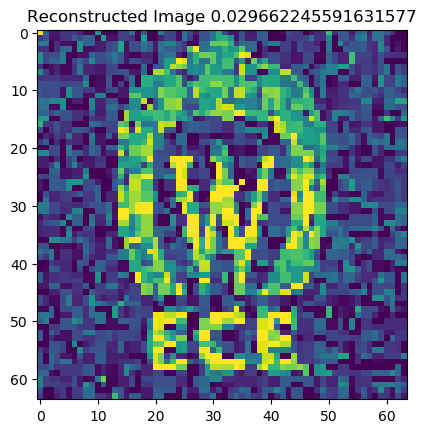

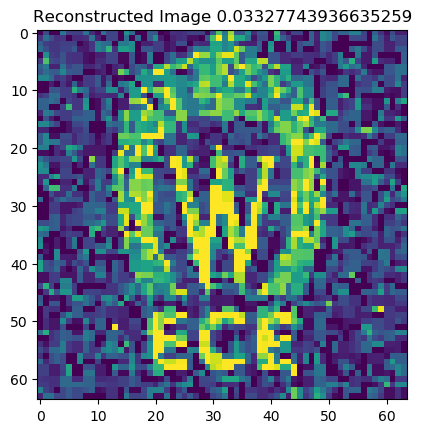

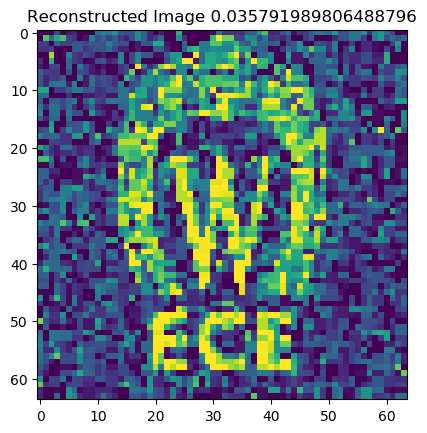

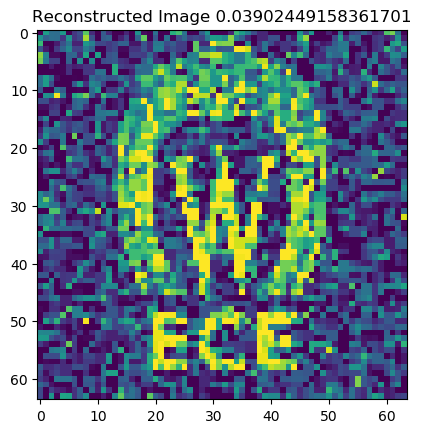

Academic license - for non-commercial use only
Academic license - for non-commercial use only
340.336351 seconds (863.10 k allocations: 927.324 MiB, 0.02% gc time)

Sure!

In [16]:
time = 100;
Pnoise = true;
phi_select = 1;
psi_select = 1;

ratio_series = [i for i = 1:10];
ratio_series = ratio_series ./ maximum(ratio_series)./1.5;

raw_img = Img2matrix("ECE.jpg", 64,64, false);
Error = zeros(length(ratio_series));

for i = 1:length(ratio_series)
    println("<======>Looping =>", i)
    ratio = ratio_series[i];
    @time y, phi, psi = GetTheMeasured(ratio, time, Pnoise, phi_select, psi_select, raw_img);
    
    #y_dic = Make_dicts(y_dic,i, y);
    #phi_dic = Make_dicts(phi_dic, i, phi);
    #psi_dic = Make_dicts(psi_dic, i, psi);
    
    @time Error[i] = Optimize(y,phi,psi,raw_img);
    #YZ_process_bar(i/ length(ratio_series));   
end
print("\nSure!");

Optimize!

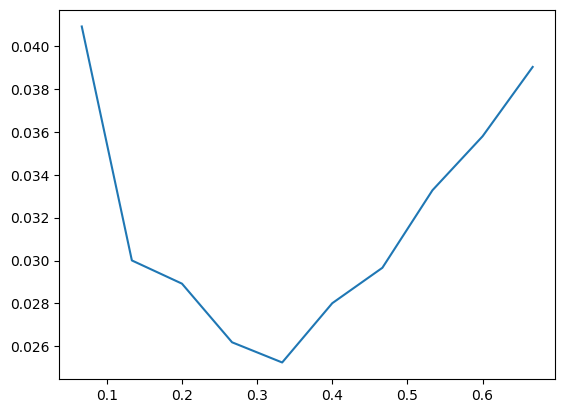

In [17]:
figure();
plot(ratio_series,Error);

<======>Looping =>1
  0.782842 seconds (71.70 k allocations: 316.211 MiB)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  1.353336 seconds (489.67 k allocations: 294.594 MiB, 37.64% gc time)
<======>Looping =>2
  0.786200 seconds (103.40 k allocations: 369.543 MiB, 7.41% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  1.644905 seconds (535.36 k allocations: 573.050 MiB, 15.44% gc time)
<======>Looping =>3
  0.663104 seconds (135.34 k allocations: 422.864 MiB)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  3.525007 seconds (581.09 k allocations: 853.379 MiB, 37.16% gc time)
<======>Looping =>4
  0.818239 seconds (167.29 k allocations: 476.215 MiB, 13.15% gc time)
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  2.998254 seconds (626.83 k allocations: 1.107 GiB, 6.35% gc time)
<======>Loopi

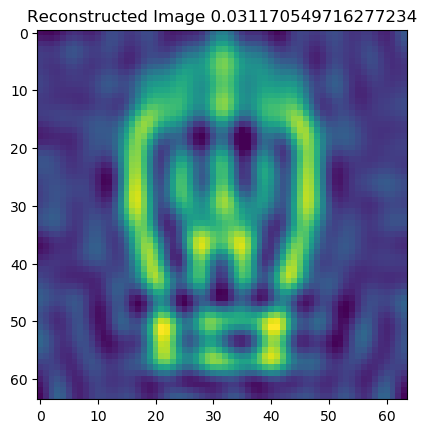

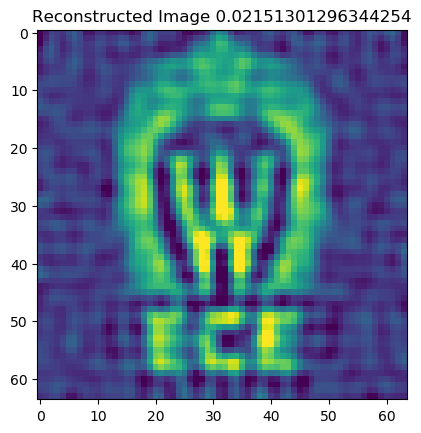

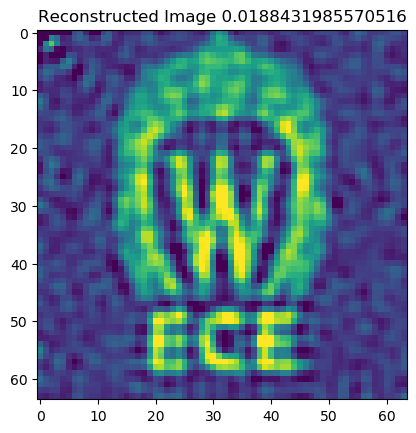

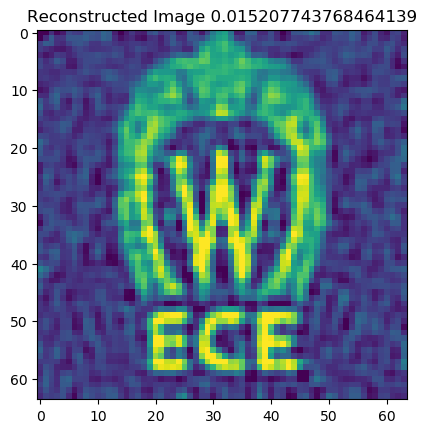

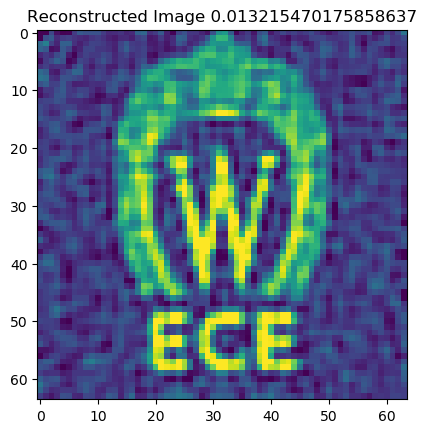

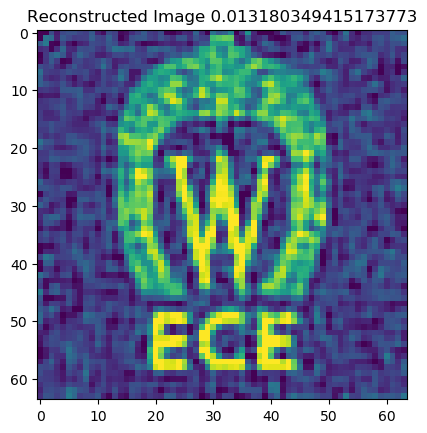

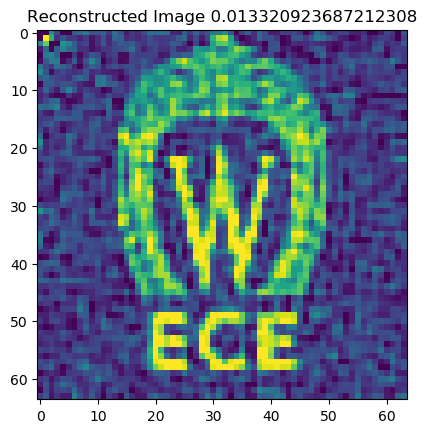

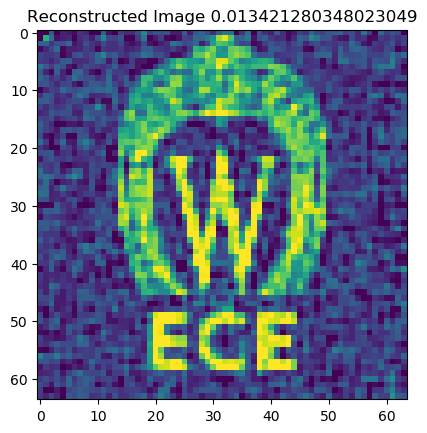

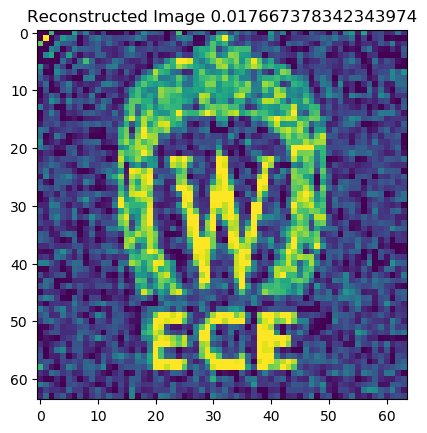

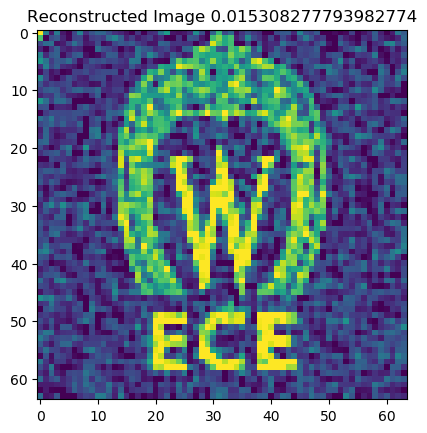


Academic license - for non-commercial use only
Academic license - for non-commercial use only
 16.859617 seconds (901.42 k allocations: 2.763 GiB, 34.67% gc time)

Sure!

In [20]:
## DCT
time = 300;
Pnoise = true;
phi_select = 1;
psi_select = 2;

ratio_series = [i for i = 1:10];
ratio_series = ratio_series ./ maximum(ratio_series)./1.5;

raw_img = Img2matrix("ECE.jpg", 64,64, false);
Error = zeros(length(ratio_series));

for i = 1:length(ratio_series)
    println("<======>Looping =>", i)
    ratio = ratio_series[i];
    @time y, phi, psi = GetTheMeasured(ratio, time, Pnoise, phi_select, psi_select, raw_img);
    
    #y_dic = Make_dicts(y_dic,i, y);
    #phi_dic = Make_dicts(phi_dic, i, phi);
    #psi_dic = Make_dicts(psi_dic, i, psi);
    
    @time Error[i] = Optimize(y,phi,psi,raw_img);
    #YZ_process_bar(i/ length(ratio_series));   
end
print("\nSure!");

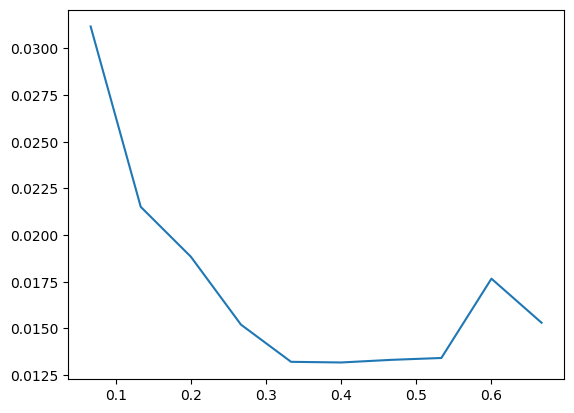

In [21]:
figure();
plot(ratio_series,Error);

## Objective 2
Find the best ratio in objective 1  
and use that value as ratio  
then set time as an array from 10 - 1000, ten elements  
do the loop like objective 1


In [37]:
function BasisScan(raw_img, time, upload_basis)
    r,c = size(raw_img);
    cycles = r*c;
    Pnoise = true;
    photon_number = time * 10^6 / cycles / (r*c) * 2; ## half open
    
    y = PMT_measure_simu(photon_number, cycles, raw_img, upload_basis, Pnoise)
    recons_vec = inv(phi) * y;
    recons_img = reshape(recons_vec,(r,c))';
    
    Error = sum((recons_img - raw_img).^2) / (r*c);
    
    
    return Error;    
end

function RasterScan(raw_img, time)
    r,c = size(raw_img);
    cycles = r*c;
    Pnoise = true;
    photon_number = time * 10^6 / cycles / (r*c);
    upload_basis = I(r*c);
    
    y = PMT_measure_simu(photon_number, cycles, raw_img, upload_basis, Pnoise);
    recons_vec = y;
    recons_img = reshape(recons_vec,(r,c))';
    
    Error = sum((recons_img - raw_img).^2) / (r*c);
    return Error; 
end

RasterScan (generic function with 1 method)

In [47]:
N = 30;
time_series = [i for i = 1:N]./N .*500;
RS_error = zeros(length(time_series));
BS_error = zeros(length(time_series));
CS_error = zeros(length(time_series));

In [49]:
raw_img = Img2matrix("ECE.jpg", 64,64, false);
r,c = size(raw_img);
phi = DMD_measure_basis(r,c, r*c, "HyperReso");
psi = IDCT_basis(r,c);

CS_cycles = Int(round(0.3 * r*c));
CS_phi = DMD_measure_basis(r,c, CS_cycles, "HyperReso");
for i = 1:length(time_series)
    time = time_series[i];
    BS_error[i] = BasisScan(raw_img, time, phi);
    RS_error[i] = RasterScan(raw_img, time);
    
    photon_number = 10^6 * time / CS_cycles /(r*c) * 2;
    y_CS = PMT_measure_simu(photon_number, CS_cycles, raw_img, CS_phi, true);    
    CS_error[i] = Optimize(y_CS,CS_phi,psi,raw_img, false);
end


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

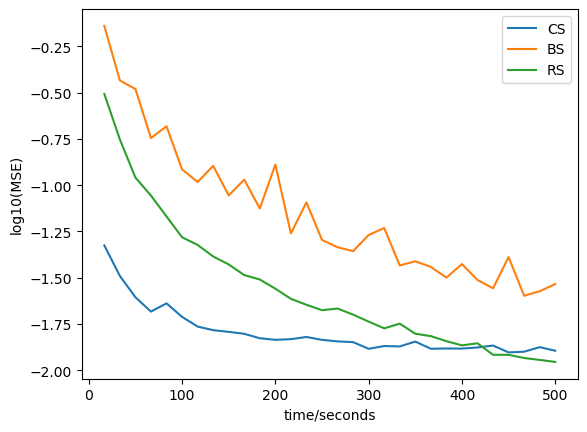

In [56]:
figure();
plot(time_series, log10.(CS_error), label = "CS");
plot(time_series, log10.(BS_error), label = "BS");
plot(time_series, log10.(RS_error), label = "RS");
legend();
xlabel("time/seconds");
ylabel("log10(MSE)");

## Skellam Distribution

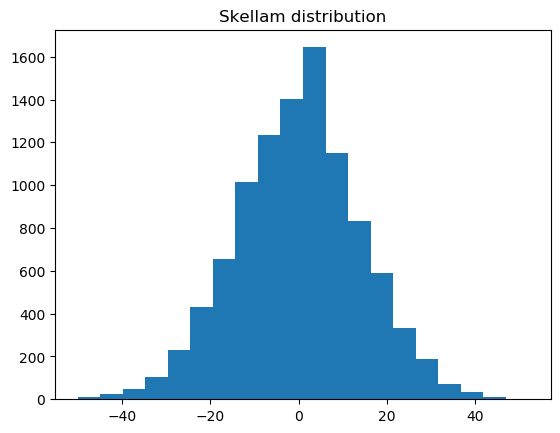

PyObject Text(0.5, 1, 'Skellam distribution')

In [92]:
GT = ones(10000,1) .* 100;
P1 = Poisson_noise(GT);
P2 = Poisson_noise(GT);
figure();
hist(P2-P1, 20);
title("Skellam distribution")
